In [2]:
import pandas as pd
#import geopandas as gpd
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import os 
import numpy as np

%matplotlib inline

In [19]:
prjFolder = "/Users/michailxyntarakis/opendata/mta/turnstile/"
prjFolder = "."

In [20]:
!ls "/Users/michailxyntarakis/opendata/mta/turnstile/"

'ls' is not recognized as an internal or external command,
operable program or batch file.


### Setting the column names of the csv file overcomes some peculiarities in the csv header

In [21]:
col_names = ['C/A', u'UNIT', u'SCP', u'STATION', u'LINENAME', u'DIVISION', u'DATE',
       u'TIME', u'DESC', u'ENTRIES',
       u'EXITS']
",".join(col_names)

'C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS'

## Load a small portion of the dataset to understand its properties

In [22]:
df = pd.read_csv(os.path.join(prjFolder, "turnstile_170701.txt"), header=0, names=col_names)

In [23]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/24/2017,00:00:00,REGULAR,6233682,2110437
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/24/2017,04:00:00,REGULAR,6233696,2110445
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/24/2017,08:00:00,REGULAR,6233712,2110473
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/24/2017,12:00:00,REGULAR,6233790,2110560
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/24/2017,16:00:00,REGULAR,6233942,2110622


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197421 entries, 0 to 197420
Data columns (total 11 columns):
C/A         197421 non-null object
UNIT        197421 non-null object
SCP         197421 non-null object
STATION     197421 non-null object
LINENAME    197421 non-null object
DIVISION    197421 non-null object
DATE        197421 non-null object
TIME        197421 non-null object
DESC        197421 non-null object
ENTRIES     197421 non-null int64
EXITS       197421 non-null int64
dtypes: int64(2), object(9)
memory usage: 16.6+ MB


In [10]:
df.isnull().sum()

C/A         0
UNIT        0
SCP         0
STATION     0
LINENAME    0
DIVISION    0
DATE        0
TIME        0
DESC        0
ENTRIES     0
EXITS       0
dtype: int64

### the dataset does not contain any null values which is a good thing. Most of the variables in are categorical strings. Only two are numeric

In [32]:
def describeCategorical(df, name):
    
    series = df[name]
    numNull = series.isnull().sum()
    numUnique = series.nunique()
    
    minNumCharacters = min(series.apply(lambda x:len(x)))
    maxNumCharacters = max(series.apply(lambda x:len(x)))
    
    stats = pd.DataFrame(data=[numNull, numUnique, minNumCharacters, maxNumCharacters], 
                     index=['numNull', 'numUnique', 'minChars', 'maxChars'],
                     columns=['stats'])
    
    stats.index.name = name 
    
    return stats

In [33]:
describeCategorical(df, 'STATION')

,stats
STATION,
numNull,0
numUnique,376
minChars,4
maxChars,15


In [53]:
def describeAllCategorical(df):

    stringColumns = df.columns[df.dtypes == np.object]

    result = [] 
    
    for colName in stringColumns:
        
        r = describeCategorical(df, colName)
        r.index.name = 'stats'
        r.rename(columns={'stats':colName}, inplace=True)
    
        result.append(r)
    
    result = pd.concat(result, axis=1)
    
    return result
    

In [54]:
describeAllCategorical(df)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC
stats,,,,,,,,,
numNull,0,0,0,0,0,0,0,0,0
numUnique,732,466,230,376,114,6,7,11888,2
minChars,4,4,8,4,1,3,10,8,7
maxChars,5,4,8,15,12,3,10,8,10


C/A      = Control Area (A002)
UNIT     = Remote Unit for a station (R051)
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
STATION  = Represents the station name the device is located at

## The relationship between the variables C/A, UNIT, CSP is unclear. What combination of them defines singularly a turnstile? 

In [55]:
df.STATION.value_counts().head()

34 ST-PENN STA     4127
FULTON ST          4057
23 ST              2981
GRD CNTRL-42 ST    2744
CANAL ST           2465
Name: STATION, dtype: int64

In [56]:
df.STATION.value_counts().tail()

ALABAMA AV        124
CYPRESS HILLS     123
VAN SICLEN AVE    111
SUTTER AV          84
CLEVELAND ST       84
Name: STATION, dtype: int64

## The C/A column can be dropped because there is 1-1 correspondance between C/A and UNIT

In [61]:
df['C/A'].nunique()

732

In [63]:
df[['C/A', 'UNIT']].drop_duplicates().shape[0]

732

# Each SCP can belong to multiple stations or UNITS 

In [ ]:
df[['STATION', 'SCP']].drop_duplicates().groupby('SCP')['STATION'].size().head()

In [ ]:
df[['UNIT', 'SCP']].drop_duplicates().groupby('SCP')['UNIT'].size().head()

In [ ]:
df[['UNIT', 'SCP']].drop_duplicates().shape

In [ ]:
df[['STATION', 'UNIT', 'SCP']].drop_duplicates().shape

# Each UNIT can belong to more than one station however judging by station names I would say that each UNIT belongs to a unique geographic station 

In [69]:
(df[['UNIT', 'STATION']]
    .drop_duplicates()
    .UNIT.value_counts()
    .reset_index()
    .rename(columns={'UNIT':'numStations', 'index':'Unit'})
).head(20)

,Unit,numStations
0,R549,4
1,R029,3
2,R550,2
3,R258,2
4,R163,2
5,R175,2
6,R044,2
7,R268,2
8,R540,2
9,R541,2


In [70]:
df[df.UNIT == 'R549'][['UNIT', 'STATION']].drop_duplicates()

,UNIT,STATION
109403,R549,NEWARK HW BMEBE
117852,R549,NEWARK BM BW
118575,R549,NEWARK C
119295,R549,NEWARK HM HE


In [71]:
df[df.UNIT == 'R029'][['UNIT', 'STATION']].drop_duplicates()

,UNIT,STATION
54812,R029,CHAMBERS ST
55861,R029,WORLD TRADE CTR
124789,R029,PARK PLACE


In [72]:
df[df.UNIT == 'R550'][['UNIT', 'STATION']].drop_duplicates()

,UNIT,STATION
113770,R550,CITY / BUS
116225,R550,LACKAWANNA


In [73]:
df[df.UNIT == 'R540'][['UNIT', 'STATION']].drop_duplicates()

,UNIT,STATION
120003,R540,PATH WTC 2
120203,R540,PATH NEW WTC


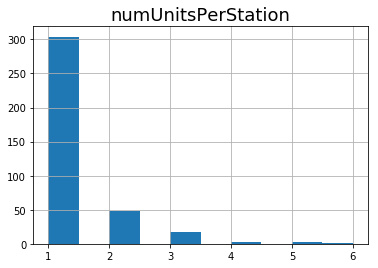

In [75]:
tmp = (df[['STATION', 'UNIT']]
    .drop_duplicates()
    .groupby(['STATION'])
    .size()
    .to_frame()
    .rename(columns={0:'numUnits'})
    .reset_index())
ax = tmp.numUnits.hist()
ax.set_title("numUnitsPerStation", fontsize=18)

In [77]:
SCP_per_station = (df[['STATION', 'UNIT', 'SCP']]
    .drop_duplicates()
    .groupby(['STATION'])
    .size()
    .to_frame()
    .rename(columns={0:'numSCP'})
    .reset_index())
SCP_per_station.sort_values('numSCP', ascending=False, inplace=True)
SCP_per_station.head()

,STATION,numSCP
61,34 ST-PENN STA,98
224,FULTON ST,96
46,23 ST,71
231,GRD CNTRL-42 ST,65
171,CANAL ST,58


In [78]:
SCP_per_station.tail()

,STATION,numSCP
81,55 ST,3
89,65 ST,3
64,39 AV,3
186,CLEVELAND ST,2
347,SUTTER AV,2


# Identify unique turnstiles

In [28]:
stations = df[['UNIT', 'STATION', 'LINENAME']].drop_duplicates()
stations.sort_values(['STATION', 'LINENAME'], inplace=True)
stations.head()

,UNIT,STATION,LINENAME
28655,R248,1 AV,L
137541,R191,103 ST,1
157914,R180,103 ST,6
44221,R314,103 ST,BC
181394,R208,103 ST-CORONA,7


In [29]:
stations.to_clipboard()

# A unit usually represents a unique station but there can be two units that represent a unique station. Example: 


"""R022	34 ST-HERALD SQ	BDFMNQRW
R023	34 ST-HERALD SQ	BDFMNQRW
R072	34 ST-HUDSON YD	7
R031	34 ST-PENN STA	123
R293	34 ST-PENN STA	123ACE
R012	34 ST-PENN STA	ACE
R013	34 ST-PENN STA	ACE
"""



# Based on the above a turnstile is defined as a unique combination of UNIT and SCP. I will create a turnstile variable that I will use later  

In [100]:
turnstile = df[['UNIT', 'SCP']].drop_duplicates()
turnstile['turnstile'] = np.arange(turnstile.shape[0])
turnstile = turnstile.merge(df[['UNIT', 'SCP', 'STATION']].drop_duplicates(), 
                            on=['UNIT', 'SCP'])
turnstile.head()

,UNIT,SCP,turnstile,STATION
0,R001,00-00-00,0,WHITEHALL S-FRY
1,R001,00-00-01,1,WHITEHALL S-FRY
2,R001,00-00-02,2,WHITEHALL S-FRY
3,R001,00-00-03,3,WHITEHALL S-FRY
4,R001,00-00-04,4,WHITEHALL S-FRY


In [101]:
turnstile.shape

(4699, 4)

In [102]:
df.shape

(197421, 12)

In [146]:
df['datetime'] = pd.to_datetime(df.DATE) + pd.to_timedelta(df.TIME)

df = df.sort_values(['UNIT', 'SCP', 'datetime'])
df.index = np.arange(df.shape[0])



In [113]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime
0,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,06/24/2017,01:00:00,REGULAR,2501701,1958296,2017-06-24 01:00:00
1,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,06/24/2017,05:00:00,REGULAR,2501733,1958313,2017-06-24 05:00:00
2,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,06/24/2017,09:00:00,REGULAR,2501733,1958313,2017-06-24 09:00:00
3,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,06/24/2017,13:00:00,REGULAR,2501733,1958313,2017-06-24 13:00:00
4,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,06/24/2017,17:00:00,REGULAR,2501733,1958313,2017-06-24 17:00:00


In [114]:
df.shape

(197421, 12)

In [162]:
df = df.merge(turnstile[['UNIT', 'SCP', 'turnstile']], on=['UNIT', 'SCP'], how='inner')

In [163]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,cumENTRIES,cumEXITS,datetime,entries,turnstile
0,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,06/24/2017,01:00:00,REGULAR,2501701,1958296,2017-06-24 01:00:00,32.0,0
1,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,06/24/2017,05:00:00,REGULAR,2501733,1958313,2017-06-24 05:00:00,0.0,0
2,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,06/24/2017,09:00:00,REGULAR,2501733,1958313,2017-06-24 09:00:00,0.0,0
3,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,06/24/2017,13:00:00,REGULAR,2501733,1958313,2017-06-24 13:00:00,0.0,0
4,A060,R001,00-00-00,WHITEHALL S-FRY,R1W,BMT,06/24/2017,17:00:00,REGULAR,2501733,1958313,2017-06-24 17:00:00,4.0,0


In [164]:
df.drop(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC'],
       inplace=True, axis=1)

In [165]:
df.head()

,cumENTRIES,cumEXITS,datetime,entries,turnstile
0,2501701,1958296,2017-06-24 01:00:00,32.0,0
1,2501733,1958313,2017-06-24 05:00:00,0.0,0
2,2501733,1958313,2017-06-24 09:00:00,0.0,0
3,2501733,1958313,2017-06-24 13:00:00,0.0,0
4,2501733,1958313,2017-06-24 17:00:00,4.0,0


In [166]:
df.shape

(197421, 5)

In [143]:
df.rename(columns={'ENTRIES':'cumENTRIES', 'EXITS':'cumEXITS'}, inplace=True)

In [126]:
df.head()

,cumENTRIES,cumEXITS,datetime,turnstile
0,2501701,1958296,2017-06-24 01:00:00,0
1,2501733,1958313,2017-06-24 05:00:00,0
2,2501733,1958313,2017-06-24 09:00:00,0
3,2501733,1958313,2017-06-24 13:00:00,0
4,2501733,1958313,2017-06-24 17:00:00,0


## Descriptives on Numeric variables 

In [167]:
df.cumENTRIES.describe()

count    1.974210e+05
mean     3.890493e+07
std      2.069815e+08
min      0.000000e+00
25%      4.903900e+05
50%      2.646989e+06
75%      6.796841e+06
max      2.130423e+09
Name: cumENTRIES, dtype: float64

In [145]:
df.cumEXITS.describe()

count    1.974210e+05
mean     3.102447e+07
std      1.852684e+08
min      0.000000e+00
25%      2.383740e+05
50%      1.482037e+06
75%      4.776935e+06
max      2.087387e+09
Name: cumEXITS, dtype: float64

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197421 entries, 0 to 197420
Data columns (total 5 columns):
cumENTRIES    197421 non-null int64
cumEXITS      197421 non-null int64
datetime      197421 non-null datetime64[ns]
entries       192722 non-null float64
turnstile     197421 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 9.0 MB


# Calculate entries from cumulative entries

In [170]:
df.shape

(197421, 5)

In [169]:
df = df.sort_values(['turnstile', 'datetime'])
df.index = np.arange(df.shape[0])

In [173]:
df['entries'] =  df.cumENTRIES.shift(-1) - df.cumENTRIES
df['exits']   =  df.cumEXITS.shift(-1) - df.cumEXITS
#df.loc[df.UNIT != df.UNIT.shift(-1), 'entries'] = np.nan
#df.loc[df.SCP  != df.SCP.shift(-1), 'entries'] = np.nan 
df.loc[df.turnstile != df.turnstile.shift(-1), 'entries'] = np.nan
df.loc[df.turnstile != df.turnstile.shift(-1), 'exits'] = np.nan
#df.loc[df.DATE != df.DATE.shift(-1), 'entries'] = np.nan

In [174]:
df.head()

,cumENTRIES,cumEXITS,datetime,entries,turnstile,exits
0,2501701,1958296,2017-06-24 01:00:00,32.0,0,17.0
1,2501733,1958313,2017-06-24 05:00:00,0.0,0,0.0
2,2501733,1958313,2017-06-24 09:00:00,0.0,0,0.0
3,2501733,1958313,2017-06-24 13:00:00,0.0,0,0.0
4,2501733,1958313,2017-06-24 17:00:00,4.0,0,0.0


In [175]:
df.entries.describe()

count    1.927220e+05
mean    -1.658525e+02
std      5.226395e+06
min     -1.610338e+09
25%      1.100000e+01
50%      8.300000e+01
75%      2.550000e+02
max      1.610338e+09
Name: entries, dtype: float64

## The mean is negative and does not make any sense. The negative mean is due to outliers

In [156]:
df[df.entries < 0].to_clipboard()

In [176]:
df[df.entries < 0][['turnstile', 'datetime', 'cumENTRIES', 'entries']]

,turnstile,datetime,cumENTRIES,entries
2516,62,2017-06-24 00:00:00,2026014447,-1.0
2517,62,2017-06-24 04:00:00,2026014446,-3.0
2520,62,2017-06-24 16:00:00,2026014443,-2.0
2521,62,2017-06-24 20:00:00,2026014441,-6.0
2522,62,2017-06-25 00:00:00,2026014435,-2.0
2523,62,2017-06-25 04:00:00,2026014433,-9.0
2524,62,2017-06-25 08:00:00,2026014424,-14.0
2525,62,2017-06-25 12:00:00,2026014410,-9.0
2526,62,2017-06-25 16:00:00,2026014401,-9.0
2527,62,2017-06-25 20:00:00,2026014392,-4.0


## You have 26 negative values 

In [178]:
df[df.entries < 0].shape, df[df.entries > 10000].shape

((1581, 6), (3, 6))

# The negative values are due to the reset of the cumulative ENTRY/EXIT variables

In [ ]:
df.loc[df.entries < 0, 'entries'] = - 1
df.loc[df.entries > 10000, 'entries'] = -1 

In [ ]:
df[df.entries < 0].shape

# you need to impute those invalid values from the means if they correspond to a regular interval 

In [ ]:
ax = df.entries.hist(figsize=(15,10), bins=range(0,4000,10), log=True)
ax.set_title("Number of turnstile entries. Irregular interval", fontsize=18)
ax.set_xlabel("Num entries", fontsize=18)
ax.set_ylabel("observations", fontsize=18)

In [ ]:
df.columns

In [ ]:
numObsPerDay = (df.groupby(['UNIT', 'SCP', 'DATE'])['entries'].size()
   .reset_index()
   .rename(columns={'entries':'numObs'})
   .sort_values('numObs', ascending=True)
)

numObsPerDay.head()

In [ ]:
(numObsPerDay.numObs.value_counts()
    .reset_index()
    .rename(columns={'numObs':"number of days", 'index':'num_turnstile_obs'})
    .sort_values('num_turnstile_obs', ascending=True)
)

## The vast majority of time there are 6 observations but there are cases you have less that need to be addressed

### For each turnstile and date, you you have an observation for 99.8 % of the time. 

In [ ]:
numTurnstiles = df[['UNIT', 'SCP']].drop_duplicates().shape[0]
numTurnstiles

In [ ]:
numTurnstiles * df.DATE.unique().shape[0]

In [ ]:
df[['UNIT', 'SCP', 'DATE']].drop_duplicates().shape[0]

In [ ]:
df[['UNIT', 'SCP', 'DATE']].drop_duplicates().shape[0] / (float(numTurnstiles) * df.DATE.unique().shape[0])

# Time intervals to standardize for  

In [ ]:
timesPerTurnstile = (df[['UNIT', 'SCP', 'TIME']].drop_duplicates()
    .groupby(['UNIT', 'SCP'])['TIME'].size()
    .reset_index()
    .rename(columns={'TIME':'numTimeIntervals'})
    .sort_values('numTimeIntervals', ascending=True)
)
timesPerTurnstile

In [ ]:
(timesPerTurnstile.numTimeIntervals
                 .value_counts()
                 .reset_index()
                 .rename(columns={'numTimeIntervals':'numTurnstiles', 'index':'numOfTimeIntervals'})
                 .sort_values('numOfTimeIntervals', ascending=True)
)

## The majority of the turnstiles report 6 time intervals. But there is a significant number that does not 

## Popular times 

In [ ]:
df.TIME.value_counts?

In [ ]:
pop_times = (df.TIME.value_counts(normalize=True)
 .reset_index()
)

pop_times['cumPercentage'] = np.cumsum(pop_times.TIME.values)
pop_times.head(20)

## 88% of the time the time reported is 0,4,12,8,16,20 or 1, 5, 9, 13, 17, 21

## Reporting times are not standardized at all 

In [ ]:
df.columns

In [ ]:
df['time'] = pd.to_timedelta(df.TIME).dt.total_seconds() / 3600

In [ ]:
df['time'].max()

In [ ]:
ax = df.time.hist(figsize=(15,10), bins=np.arange(0,24,0.1), log=False)
ax.set_title("Distribution of Reported Times\(bin is 6 minutes)", fontsize=18)
ax.set_xlabel("Hours", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)
ax.set_xlim([0,24])

In [ ]:
df.columns

In [ ]:
df.sort_values(['UNIT', 'SCP', 'datetime'], inplace=True)

In [ ]:
df['DT'] =  df.datetime.shift(-1) - df.datetime
df.loc[df.SCP != df.SCP.shift(-1), 'DT'] = np.nan
df.loc[df.UNIT != df.UNIT.shift(-1), 'DT'] = np.nan

In [ ]:
df.head(100)

In [ ]:
df['DT'].unique().shape

In [ ]:
df['DT'].min()

In [ ]:
df['DT'].max()

In [ ]:
x.max()

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

x = df['DT'].dropna().dt.total_seconds() / 3600


ax.hist(x, bins=np.arange(0.1,122.1, 1), log=True, color='grey', alpha=0.5)

ax.set_title("Hours between successive measurements", fontsize=18)


ax.grid(True)
ax.set_xlabel("Hours between successive measurements",fontsize=18)
ax.set_ylabel("Freq", fontsize=18)
#ax.hist(x)

In [ ]:
df.columns

In [ ]:
df.set_index(['UNIT', 'SCP'], inplace=True)

In [ ]:
df.head()

In [ ]:
df2 = df[['UNIT', 'SCP', 'STATION', 'datetime', 'cumENTRIES', 'entries', 'time', 'DT']].copy()

In [ ]:
df2.set_index(['UNIT', 'SCP'], inplace=True)

In [ ]:
df2.loc['R001', '00-00-00']

In [ ]:
from datetime import date, timedelta

In [ ]:
date(2017, 8, 12) - timedelta(days=7) * 2

In [ ]:
timedelta(days=7)

In [ ]:
#http://web.mta.info/developers/data/nyct/turnstile/turnstile_141018.txt

start_date = date(2014, 10, 18)
end_date   = date(2017, 8, 26)

start_date = date(2010, 06, 05)

#Saturday, June 05, 2010
#http://web.mta.info/developers/data/nyct/turnstile/turnstile_100505.txt
end_date = date(2014, 10, 18)

In [ ]:
mta_urls = [] 
d = start_date
while d < end_date:
    
  
    
    
    # http://web.mta.info/developers/data/nyct/turnstile/turnstile_170826.txt
    #print(d.strftime(%H))
    #s = d.strftime("%y%m%d")
    link = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_%s.txt" % d.strftime("%y%m%d")
    d = d + timedelta(days=7)
    
    mta_urls.append(link)
    #print(link)
    

In [ ]:
len(mta_urls)

In [ ]:
import wget

In [ ]:
def readAllFilesNewFormat(mta_urls, out_file):
    
    result = [] 
    
    for url in mta_urls:

        try: 
            
            filename = wget.download(url)
            print(filename)
            df = pd.read_csv(filename, header=0, names=col_names)

            df['datetime'] = pd.to_datetime(df.DATE) + pd.to_timedelta(df.TIME)

            df = df.sort_values(['UNIT', 'SCP', 'datetime'])
            df.index = np.arange(df.shape[0])
            df.rename(columns={'ENTRIES':'cumENTRIES', 'EXITS':'cumEXITS'}, inplace=True)

            df['entries'] =  df.cumENTRIES.shift(-1) - df.cumENTRIES
            df.loc[df.SCP != df.SCP.shift(-1), 'entries'] = np.nan
            df.loc[df.UNIT != df.UNIT.shift(-1), 'entries'] = np.nan    

            df['exits'] =  df.cumEXITS.shift(-1) - df.cumEXITS
            df.loc[df.SCP != df.SCP.shift(-1), 'exits'] = np.nan
            df.loc[df.UNIT != df.UNIT.shift(-1), 'exits'] = np.nan  


            df['time'] = pd.to_timedelta(df.TIME).dt.total_seconds() / 3600

            df['DT'] =  df.datetime.shift(-1) - df.datetime
            df.loc[df.SCP != df.SCP.shift(-1), 'DT'] = np.nan
            df.loc[df.UNIT != df.UNIT.shift(-1), 'DT'] = np.nan


            df2 = df[['UNIT', 'SCP', 'STATION', 'datetime', 
                   'cumENTRIES', 'cumEXITS', 'entries', 'exits', 'time', 'DT']].copy()
            
            
            df2.to_hdf(out_file,'table',append=True)
        
        except Exception:
            
            print("ERROR in processing %s" % filename)
            
    

In [ ]:
readAllFiles(mta_urls, '/Users/michailxyntarakis/opendata/mta/turnstile/turnstiles_141025_170826.hdf')

In [ ]:
filename = wget.download("http://web.mta.info/developers/data/nyct/turnstile/turnstile_100505.txt")

In [ ]:
mta_urls[0]

In [ ]:
columns2="""C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8""".split(",")

In [ ]:
df = pd.read_csv(filename, header=0, names=columns2)

In [ ]:
df.columns

In [ ]:
result = [] 

for i in range(1, 9):

    cols = [u'UNIT', u'SCP',  u'DATE%d' % i, u'TIME%d' % i , u'ENTRIES%d' % i, u'EXITS%d' % i]
    df2 = df[cols].copy() 
    df2.columns = ['UNIT', 'SCP', 'DATE', 'TIME', 'cumENTRIES', 'cumEXITS']
    
    result.append(df2)
    
result = pd.concat(result)


In [ ]:
result.head()

In [ ]:
df = result.copy()

In [ ]:
df.head()

In [ ]:
df['datetime'] = pd.to_datetime(df.DATE) + pd.to_timedelta(df.TIME)

df = df.dropna()
df = df.sort_values(['UNIT', 'SCP', 'datetime'])
df.index = np.arange(df.shape[0])


df['entries'] =  df.cumENTRIES.shift(-1) - df.cumENTRIES
df.loc[df.SCP != df.SCP.shift(-1), 'entries'] = np.nan
df.loc[df.UNIT != df.UNIT.shift(-1), 'entries'] = np.nan    

df['exits'] =  df.cumEXITS.shift(-1) - df.cumEXITS
df.loc[df.SCP != df.SCP.shift(-1), 'exits'] = np.nan
df.loc[df.UNIT != df.UNIT.shift(-1), 'exits'] = np.nan  


df['time'] = pd.to_timedelta(df.TIME).dt.total_seconds() / 3600

df['DT'] =  df.datetime.shift(-1) - df.datetime
df.loc[df.SCP != df.SCP.shift(-1), 'DT'] = np.nan
df.loc[df.UNIT != df.UNIT.shift(-1), 'DT'] = np.nan


df2 = df[['UNIT', 'SCP', 'datetime', 
       'cumENTRIES', 'cumEXITS', 'entries', 'exits', 'time', 'DT']].copy()

In [ ]:
df.head()

In [ ]:
def readAllFilesOldFormat(mta_urls, out_file):
    
    result = [] 
    
    for url in mta_urls:

        try: 
            
            filename = wget.download(url)
            print(filename)
            
            df = pd.read_csv(filename, header=0, names=columns2)
            
            result = [] 

            for i in range(1, 9):

                cols = [u'UNIT', u'SCP',  u'DATE%d' % i, u'TIME%d' % i , u'ENTRIES%d' % i, u'EXITS%d' % i]
                tmp = df[cols].copy() 
                tmp.columns = ['UNIT', 'SCP', 'DATE', 'TIME', 'cumENTRIES', 'cumEXITS']

                result.append(tmp)

            result = pd.concat(result)

            df = result 

            df['datetime'] = pd.to_datetime(df.DATE) + pd.to_timedelta(df.TIME)

            df = df.dropna()
            df = df.sort_values(['UNIT', 'SCP', 'datetime'])
            df.index = np.arange(df.shape[0])


            df['entries'] =  df.cumENTRIES.shift(-1) - df.cumENTRIES
            df.loc[df.SCP != df.SCP.shift(-1), 'entries'] = np.nan
            df.loc[df.UNIT != df.UNIT.shift(-1), 'entries'] = np.nan    

            df['exits'] =  df.cumEXITS.shift(-1) - df.cumEXITS
            df.loc[df.SCP != df.SCP.shift(-1), 'exits'] = np.nan
            df.loc[df.UNIT != df.UNIT.shift(-1), 'exits'] = np.nan  


            df['time'] = pd.to_timedelta(df.TIME).dt.total_seconds() / 3600

            df['DT'] =  df.datetime.shift(-1) - df.datetime
            df.loc[df.SCP != df.SCP.shift(-1), 'DT'] = np.nan
            df.loc[df.UNIT != df.UNIT.shift(-1), 'DT'] = np.nan


            df2 = df[['UNIT', 'SCP', 'datetime', 
                   'cumENTRIES', 'cumEXITS', 'entries', 'exits', 'time', 'DT']].copy()
            
            
            df2.to_hdf(out_file,'table',append=True)
        
        except Exception:
            
            print("ERROR in processing %s" % filename)
            

In [ ]:
mta_urls[-1]

In [ ]:
readAllFilesOldFormat(mta_urls, '/Users/michailxyntarakis/opendata/mta/turnstile/turnstiles_100605_141025.hdf')

In [ ]:
df = pd.read_hdf('/Users/michailxyntarakis/opendata/mta/turnstile/turnstiles_100605_141025.hdf', 'table')

In [ ]:
df.info()

# Records that go negative 

In [ ]:
df.head()

In [ ]:
df['date'] = df.datetime.dt.date

In [ ]:
df[df.entries < 0].shape[0]

In [ ]:
df[df.entries > 5000].shape[0]

In [ ]:
df[df.entries > 10 ** 5].shape